In [72]:
#import all the necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle
import re
from scipy.sparse import hstack
import pickle
from sklearn.preprocessing import MinMaxScaler
import sys

In [3]:
data=pd.read_csv("C:\\Users\\harshita.chigati\\Desktop\\Python files\\NLP\\BigBasket Products.csv")
data.head(3)

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."


In [4]:
print ('Number of data points : ', data.shape[0],'\nNumber of features/variables:', data.shape[1])

Number of data points :  27555 
Number of features/variables: 10


In [5]:
# each product/item has 10 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['index', 'product', 'category', 'sub_category', 'brand', 'sale_price',
       'market_price', 'type', 'rating', 'description'],
      dtype='object')

In [6]:
# info about the data features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


In [7]:
# to know null values in each column
data.isnull().sum()

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

In [8]:
# selecting the required columns from dataframe for analysis and model building
data=data[['product','category','sub_category','brand','type','description','sale_price','market_price']]
data.head(2)

,product,category,sub_category,brand,type,description,sale_price,market_price
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,Hair Oil & Serum,This Product contains Garlic Oil that is known...,220.0,220.0
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,Water & Fridge Bottles,"Each product is microwave safe (without lid), ...",180.0,180.0


In [9]:
# will remove rows with missing value in columns product,brand,description
data=data[~data['product'].isna()] # removing row with missing product value
data=data[~data['brand'].isna()]
data=data[~data['description'].isna()]
data.shape

(27439, 8)

In [10]:
# splitting data into train and test 
from sklearn.model_selection import train_test_split

data_train,data_test=train_test_split(data,test_size=0.2,random_state=33)

print('data_train shape',data_train.shape)
print('data_test shape',data_test.shape)

data_train shape (21951, 8)
data_test shape (5488, 8)


In [11]:
# resetting index
data_train=data_train.reset_index(drop=True)
data_test=data_test.reset_index(drop=True)

## EDA on Train data

In [12]:
data_train.columns

Index(['product', 'category', 'sub_category', 'brand', 'type', 'description',
       'sale_price', 'market_price'],
      dtype='object')

In [13]:
# Univariate Analysis for feature 'product'
data_train['product'].describe()

count                            21951
unique                           19301
top       Turmeric Powder/Arisina Pudi
freq                                21
Name: product, dtype: object

In [14]:
# Univariate Analysis For feature category
data_train['category'].describe()

count                21951
unique                  11
top       Beauty & Hygiene
freq                  6306
Name: category, dtype: object

In [15]:
d1=data_train['category'].value_counts().reset_index()
d1.columns=['category','counts']
d1

,category,counts
0,Beauty & Hygiene,6306
1,Gourmet & World Food,3736
2,"Kitchen, Garden & Pets",2838
3,Snacks & Branded Foods,2245
4,Cleaning & Household,2128
5,"Foodgrains, Oil & Masala",2099
6,Beverages,701
7,"Bakery, Cakes & Dairy",685
8,Baby Care,495
9,Fruits & Vegetables,443


In [16]:
# calculating the percentage distribution of the 'category' column
cate=data_train['category'].value_counts(normalize=True).reset_index() # creating data frame with name cate for further processing
cate['cumulative%']= cate['category'].cumsum()
cate.columns=['category','%','cumulative%']
cate

,category,%,cumulative%
0,Beauty & Hygiene,0.287276,Beauty & Hygiene
1,Gourmet & World Food,0.170197,Beauty & HygieneGourmet & World Food
2,"Kitchen, Garden & Pets",0.129288,"Beauty & HygieneGourmet & World FoodKitchen, G..."
3,Snacks & Branded Foods,0.102273,"Beauty & HygieneGourmet & World FoodKitchen, G..."
4,Cleaning & Household,0.096943,"Beauty & HygieneGourmet & World FoodKitchen, G..."
5,"Foodgrains, Oil & Masala",0.095622,"Beauty & HygieneGourmet & World FoodKitchen, G..."
6,Beverages,0.031935,"Beauty & HygieneGourmet & World FoodKitchen, G..."
7,"Bakery, Cakes & Dairy",0.031206,"Beauty & HygieneGourmet & World FoodKitchen, G..."
8,Baby Care,0.022550,"Beauty & HygieneGourmet & World FoodKitchen, G..."
9,Fruits & Vegetables,0.020181,"Beauty & HygieneGourmet & World FoodKitchen, G..."


TypeError: unsupported operand type(s) for -: 'str' and 'float'

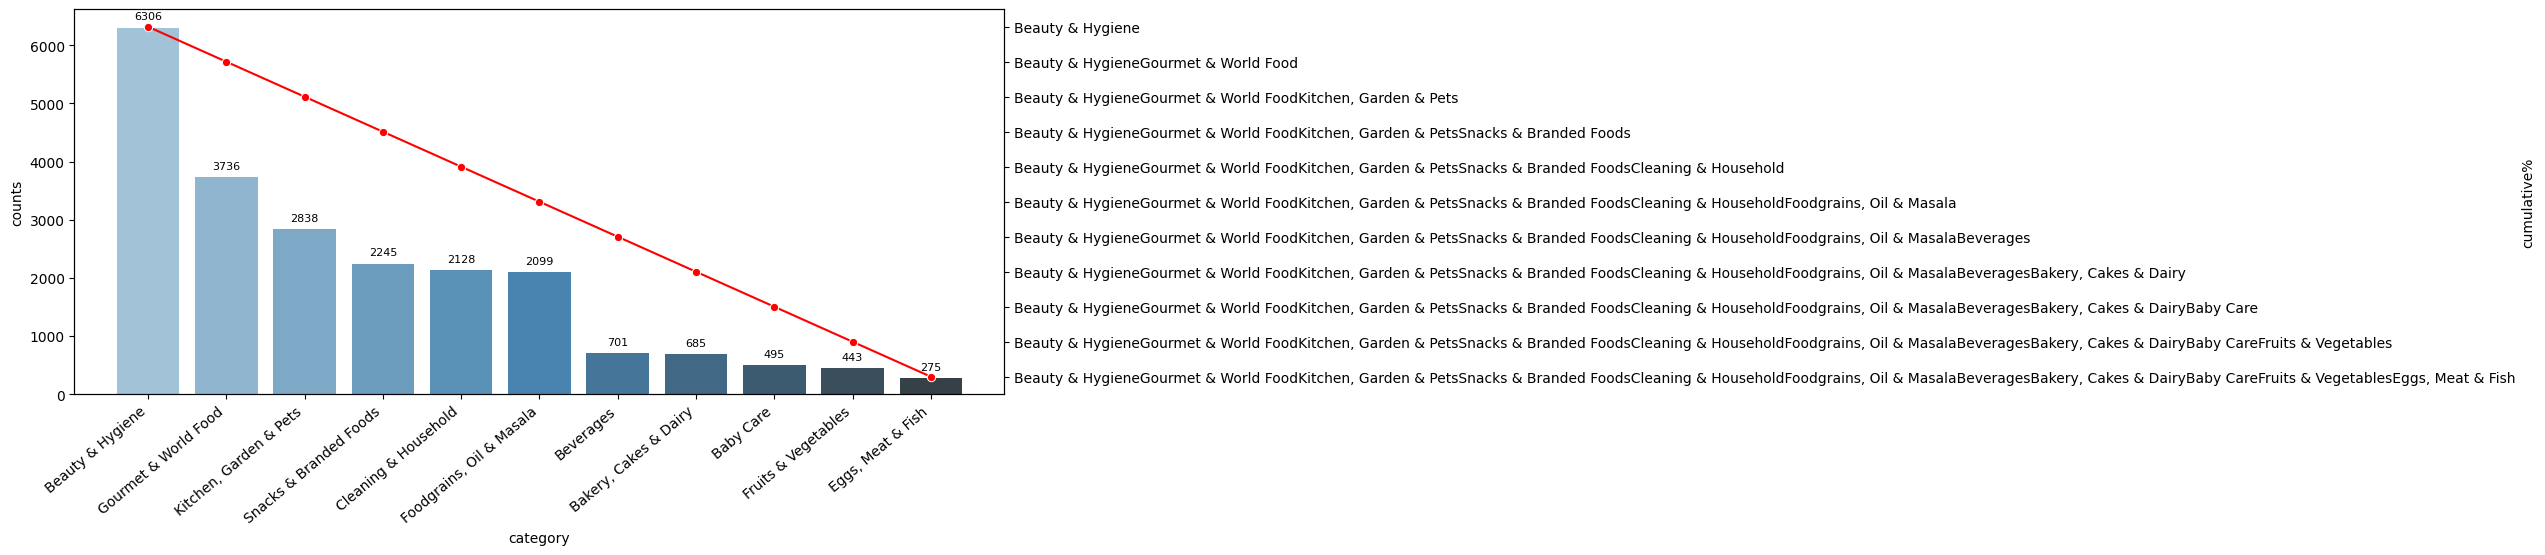

In [17]:
plt.figure(figsize=(12,5))
ax=sns.barplot(x='category',y='counts',data=d1,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right")
for bar in ax.patches: # annotating bar graph 
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
ax2=ax.twinx() # to include line graph with bar graph in same plot
ax2=sns.lineplot(x='category',y='cumulative%',data=cate,marker="o",color='r')

for i,value in enumerate(cate['cumulative%'].values): # to annotate line plot 
    ax2.text(cate['category'].values[i],cate['cumulative%'].values[i]-0.0025,np.round(value*100,2))
    # putting text of cum_% value with respect to its x,y values
    #ax2,text(x-coordinate,ycordinate,value) # position of annotation
ax.set_title('Univariate Analysis of Category') # title the graph
plt.tight_layout()
plt.show()

In [18]:
# For feature 'sub_category'
data_train['sub_category'].describe()

count         21951
unique           90
top       Skin Care
freq           1814
Name: sub_category, dtype: object

In [19]:
data_train['sub_category'].value_counts()

sub_category
Skin Care                   1814
Health & Medicine            927
Hair Care                    830
Fragrances & Deos            822
Storage & Accessories        821
                            ... 
Mutton & Lamb                 18
Water                         14
Flower Bouquets, Bunches       8
Pork & Other Meats             2
Marinades                      1
Name: count, Length: 90, dtype: int64

In [20]:
data_train['sub_category'].value_counts(normalize=True)*100 # To get percentage


sub_category
Skin Care                   8.263860
Health & Medicine           4.223042
Hair Care                   3.781149
Fragrances & Deos           3.744704
Storage & Accessories       3.740149
                              ...   
Mutton & Lamb               0.082001
Water                       0.063778
Flower Bouquets, Bunches    0.036445
Pork & Other Meats          0.009111
Marinades                   0.004556
Name: proportion, Length: 90, dtype: float64

In [21]:
data_train['sub_category'].unique() # to get unique values of sub_category


array(['Organic Staples', 'Frozen Veggies & Snacks',
       'Rice & Rice Products', 'Cooking & Baking Needs',
       'Drinks & Beverages', 'Fragrances & Deos', 'All Purpose Cleaners',
       'Snacks, Dry Fruits, Nuts', 'Storage & Accessories',
       'Fresheners & Repellents', 'Diapers & Wipes', 'Masalas & Spices',
       'Tea', 'Snacks & Namkeen', 'Party & Festive Needs',
       'Cereals & Breakfast', 'Tinned & Processed Food',
       'Health & Medicine', 'Dry Fruits', 'Pooja Needs', 'Dairy',
       'Appliances & Electricals', 'Hair Care', 'Ready To Cook & Eat',
       'Pet Food & Accessories', 'Skin Care', 'Crockery & Cutlery',
       "Men's Grooming", 'Fish & Seafood', 'Pasta, Soup & Noodles',
       'Organic Fruits & Vegetables', 'Oils & Vinegar',
       'Spreads, Sauces, Ketchup', 'Steel Utensils', 'Bakeware',
       'Oral Care', 'Detergents & Dishwash', 'Bath & Hand Wash',
       'Cakes & Pastries', 'Sauces, Spreads & Dips', 'Fresh Vegetables',
       'Noodle, Pasta, Vermicelli',

In [22]:
#  top 10 sub_categories
subcategory_count=Counter(list(data_train['sub_category']))
subcategory_count.most_common(10)

[('Skin Care', 1814),
 ('Health & Medicine', 927),
 ('Hair Care', 830),
 ('Fragrances & Deos', 822),
 ('Storage & Accessories', 821),
 ('Bath & Hand Wash', 779),
 ('Masalas & Spices', 700),
 ('Crockery & Cutlery', 694),
 ('Snacks, Dry Fruits, Nuts', 677),
 ("Men's Grooming", 648)]

In [23]:
d1=data_train['sub_category'].value_counts().reset_index()[0:10] # selecting top 10 sub categories
d1.columns=['sub_category','counts'] # renaming colimns
d1

,sub_category,counts
0,Skin Care,1814
1,Health & Medicine,927
2,Hair Care,830
3,Fragrances & Deos,822
4,Storage & Accessories,821
5,Bath & Hand Wash,779
6,Masalas & Spices,700
7,Crockery & Cutlery,694
8,"Snacks, Dry Fruits, Nuts",677
9,Men's Grooming,648


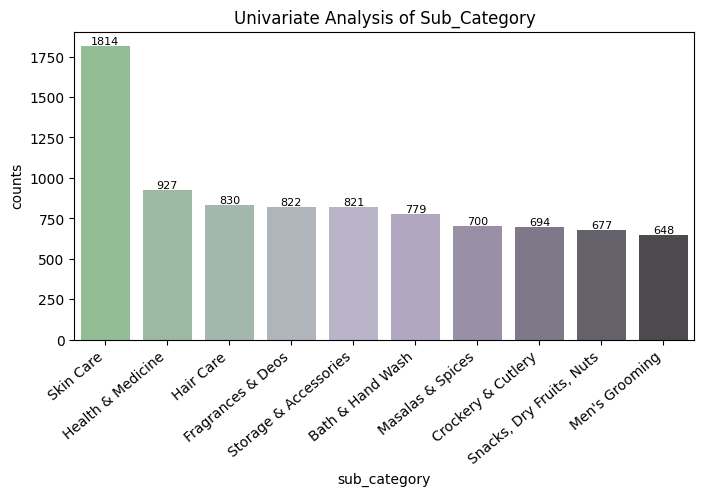

In [24]:
plt.figure(figsize=(8,4))
ax=sns.barplot(x='sub_category',y='counts',data=d1,palette="Accent_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right")

# annotating values
for bar in ax.patches: # annotating bar graph 
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 3.5),
                   textcoords='offset points')
ax.set_title('Univariate Analysis of Sub_Category') # title the graph

plt.show()

In [25]:
# For Feature 'Brand'
data_train['brand'].describe()

count      21951
unique      2195
top       Fresho
freq         506
Name: brand, dtype: object

In [26]:
#  top 10 brand
brand_count=Counter(list(data_train['brand']))
brand_count.most_common(10)

[('Fresho', 506),
 ('bb Royal', 429),
 ('BB Home', 350),
 ('DP', 194),
 ('Fresho Signature', 133),
 ('bb Combo', 130),
 ('Amul', 120),
 ('GoodDiet', 118),
 ('Dabur', 112),
 ('INATUR ', 111)]

In [27]:
# percentage of top 10 brands
(data_train['brand'].value_counts(normalize=True)*100)[:10]

brand
Fresho              2.305134
bb Royal            1.954353
BB Home             1.594460
DP                  0.883787
Fresho Signature    0.605895
bb Combo            0.592228
Amul                0.546672
GoodDiet            0.537561
Dabur               0.510227
INATUR              0.505672
Name: proportion, dtype: float64

In [28]:
# For Feature 'type'
data_train['type'].describe()

count         21951
unique          423
top       Face Care
freq           1181
Name: type, dtype: object

In [29]:
#  top 10 type of products
type_count=Counter(list(data_train['type']))
type_count.most_common(10)

[('Face Care', 1181),
 ('Ayurveda', 444),
 ("Men's Deodorants", 407),
 ('Shampoo & Conditioner', 364),
 ('Containers Sets', 343),
 ('Glassware', 327),
 ('Bathing Bars & Soaps', 308),
 ('Blended Masalas', 306),
 ('Gourmet Tea & Tea Bags', 276),
 ('Body Care', 274)]

In [30]:
# percentage of top 10 types
(data_train['type'].value_counts(normalize=True)*100)[:10]

type
Face Care                 5.380165
Ayurveda                  2.022687
Men's Deodorants          1.854130
Shampoo & Conditioner     1.658239
Containers Sets           1.562571
Glassware                 1.489682
Bathing Bars & Soaps      1.403125
Blended Masalas           1.394014
Gourmet Tea & Tea Bags    1.257346
Body Care                 1.248235
Name: proportion, dtype: float64

### sales_price

In [31]:
#  top sale_price
saleprice_count=Counter(list(data_train['sale_price']))
saleprice_count.most_common(10)

[(99.0, 325),
 (50.0, 260),
 (199.0, 248),
 (299.0, 240),
 (150.0, 237),
 (60.0, 232),
 (149.0, 203),
 (120.0, 197),
 (225.0, 197),
 (75.0, 194)]

In [33]:
data_train['sale_price'].value_counts().sort_index(ascending=False)


sale_price
12500.00     1
10090.00     1
8184.44      1
7999.00      1
7299.00      1
            ..
7.50         2
6.00         7
5.00        16
3.00         1
2.45         1
Name: count, Length: 2891, dtype: int64

<Axes: xlabel='sale_price', ylabel='Proportion'>

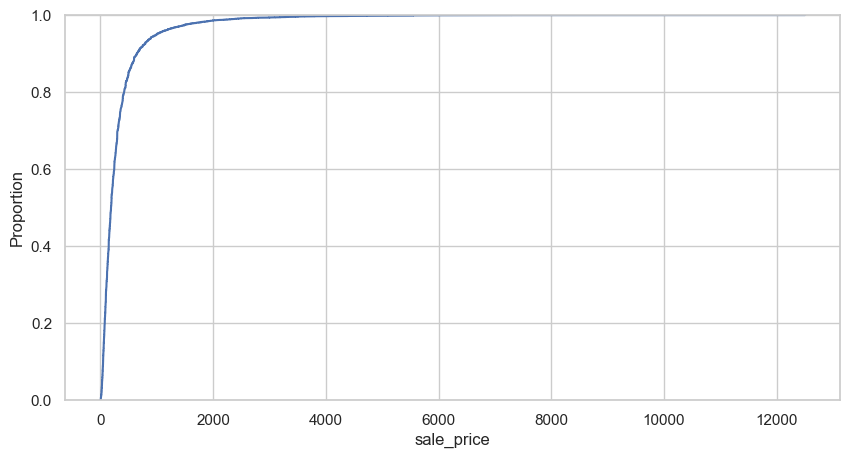

In [34]:
#CDF of sale_price
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
sns.ecdfplot(data_train['sale_price'])

<Axes: ylabel='sale_price'>

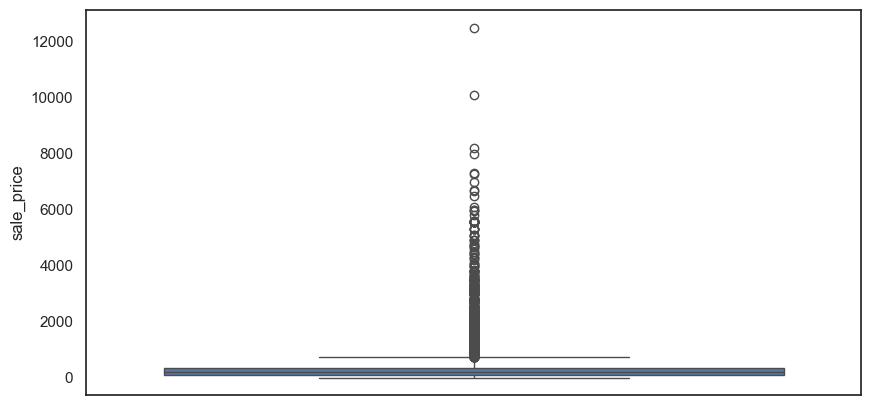

In [35]:
# Univariate analysis of sale_price
#Plotting of sale_price variable
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white')
sns.boxplot(y=data_train['sale_price'])

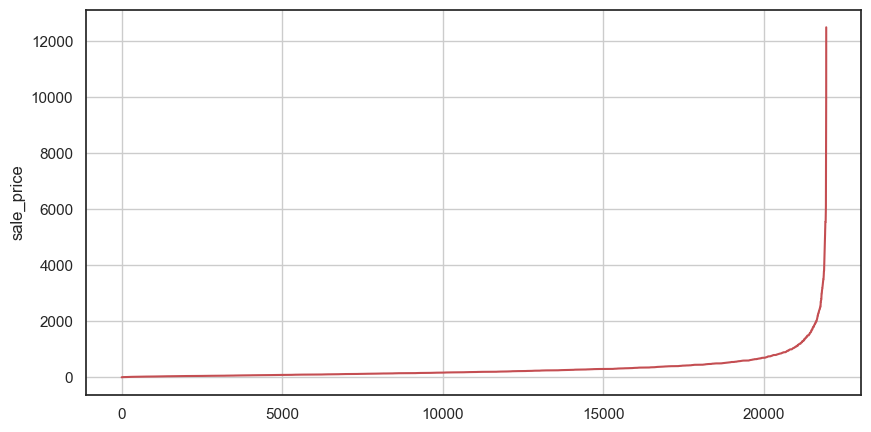

In [36]:
ypoints=np.array(data_train['sale_price'].sort_values())
plt.plot(ypoints,'r-')
plt.ylabel('sale_price')
plt.grid()
plt.show()

In [37]:
# data with sale price greater than 
data_saleprice=data_train[data_train['sale_price']>2000]
data_saleprice.shape

(303, 8)

In [38]:
data_train=data_train[data_train['sale_price']<=2000]
print("No. of data points after removing sale_price outliers:",data_train.shape[0])

No. of data points after removing sale_price outliers: 21648


### Description feature

In [39]:
data_train['description'].value_counts()


description
A brand inspired by the Greek goddess of victory, it personifies strength, speed and energy and it launched its first perfume in 1929. Since then, a wide assortment of fragrance collections has hit the marketplace with refreshing, and eye-catching proposals that capture the essence and lifestyle of today´s man and woman.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [40]:
data_train['description'].isna().sum() # to check for any missing values

0

In [41]:
data_train[data_train['description']==u' '].any().sum() # to check for just space in description

0

## Data Preprocessing


In [42]:
# we use the list of stop words that are downloaded from nltk lib.
import nltk # to download only once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

list of stop words: {"hadn't", 'yourselves', 'that', 'both', 'over', 'each', 'ourselves', 'once', 'very', 'd', 'from', "you'd", 'nor', 'same', 'he', 'down', "aren't", 'our', 'through', 'too', 'other', 'aren', 'until', 'should', 'off', 'own', 'out', "couldn't", 'while', 'into', 'whom', 'yours', 'only', 'can', "wouldn't", 'are', 'who', 'some', 'those', 'here', 'm', 'wasn', 'herself', 'under', 'now', "mustn't", 'himself', 'to', 'theirs', 'her', 'haven', 'll', 'doing', 'these', 'up', 'so', 'when', 'ours', 'we', 'its', 'yourself', 'weren', 'hers', "wasn't", 'shan', 'just', "mightn't", 'my', 'won', 'what', 'mustn', "you'll", 'it', 'ma', "needn't", 'do', 'at', 'couldn', "it's", 'was', 're', 'again', 'or', 'me', 'of', "you're", 'after', 'about', 'don', 'doesn', "you've", 'as', "won't", "isn't", 'which', 'by', 'for', 'but', 'between', 'am', 'the', 'needn', 'does', 'did', 'isn', 'them', "shan't", 'with', "haven't", 'itself', 'his', 'because', 'have', 'hadn', 'be', 'they', 'themselves', 'against'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harshita.chigati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Categorical features

In [43]:
# preprocressing category feature
def preprocess_categorical(data,column_name):
    """ fuction to preprocess categorical data column"""
    
    data[column_name]=data[column_name].str.replace('&','_') # replacing & with _
    data[column_name]=data[column_name].str.replace(',','_') # replacing , with _
    data[column_name]=data[column_name].str.replace("'",'') #replacing ' with ''(no space)
    data[column_name]=data[column_name].str.replace(" ",'') # removing white spaces
    data[column_name]=data[column_name].str.lower() # to lower case
    data[column_name]=data[column_name].str.strip() # removing trailing and leading white space
    
    return data[column_name]

In [44]:
data_train['category']=preprocess_categorical(data_train,'category')
data_train['category'].unique() # to check

array(['foodgrains_oil_masala', 'snacks_brandedfoods',
       'gourmet_worldfood', 'beauty_hygiene', 'cleaning_household',
       'kitchen_garden_pets', 'babycare', 'beverages',
       'bakery_cakes_dairy', 'eggs_meat_fish', 'fruits_vegetables'],
      dtype=object)

In [45]:
data_train['sub_category']=preprocess_categorical(data_train,'sub_category')
data_train['sub_category'].unique()

array(['organicstaples', 'frozenveggies_snacks', 'rice_riceproducts',
       'cooking_bakingneeds', 'drinks_beverages', 'fragrances_deos',
       'allpurposecleaners', 'snacks_dryfruits_nuts',
       'storage_accessories', 'fresheners_repellents', 'diapers_wipes',
       'masalas_spices', 'tea', 'snacks_namkeen', 'party_festiveneeds',
       'cereals_breakfast', 'tinned_processedfood', 'dryfruits',
       'health_medicine', 'poojaneeds', 'dairy', 'appliances_electricals',
       'haircare', 'readytocook_eat', 'petfood_accessories', 'skincare',
       'crockery_cutlery', 'mensgrooming', 'fish_seafood',
       'pasta_soup_noodles', 'organicfruits_vegetables',
       'spreads_sauces_ketchup', 'steelutensils', 'bakeware', 'oralcare',
       'detergents_dishwash', 'bath_handwash', 'cakes_pastries',
       'sauces_spreads_dips', 'freshvegetables',
       'noodle_pasta_vermicelli', 'bins_bathroomware',
       'mops_brushes_scrubs', 'chocolates_biscuits',
       'healthdrink_supplement', 'brea

In [46]:
data_train['brand']=preprocess_categorical(data_train,'brand')
data_train['brand'].nunique()


2158

In [47]:
data_train['type']=preprocess_categorical(data_train,'type')
data_train['type'].nunique()


422

In [48]:
from tqdm import tqdm
import re
def preprocess_description(text):
    preprocessed_description=[]
    for description in tqdm(text):
        
        #Delete all the data which are present in the brackets
        description = re.sub(r'\([^()]*\)',' ',description)
        
        #removing urls
        description = re.sub(r'http\S+',' ',description)
        description = re.sub('[^A-Za-z]+', ' ', description) # remove all characters except a-z and A-Z and replace with white space
        # https://gist.github.com/sebleier/554280
        description = ' '.join(word for word in description.split() if word.lower() not in stop_words) # removing stop words
        description = ' '.join(word for word in description.split() if len(word)>2) # removing single letter and two letter words
        description = description.lower().strip()
        preprocessed_description.append(description)
        
    return preprocessed_description
preprocessed_description=preprocess_description(data_train['description'].values)

100%|█████████████████████████████████████████████████████████████████████████| 21648/21648 [00:01<00:00, 11380.31it/s]


In [49]:
data_train['description']=preprocessed_description
data_train

,product,category,sub_category,brand,type,description,sale_price,market_price
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.00,60.0
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.00,125.0
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.00,225.0
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.50,65.0
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.00,10.0
...,...,...,...,...,...,...,...,...
21946,Tea Tree Anti Imperfection Daily Solution,beauty_hygiene,skincare,biotique,facecare,biotique tea tree anti imperfection daily solu...,420.00,560.0
21947,Intimate Lightening Serum,beauty_hygiene,skincare,namyaa,intimatewash_care,adore flawless skin wish perfect skin tone fee...,750.00,750.0
21948,Paw'sitively Smooth Paw Butter For Dogs,kitchen_garden_pets,petfood_accessories,captainzack,petcleaning_grooming,paw sitively smooth protects lovely pooch paws...,350.00,350.0
21949,Colorsilk Hair Colour With Keratin,beauty_hygiene,haircare,revlon,haircolor,colorsilk ammonia permanent hair colour infuse...,413.25,435.0


In [50]:
print('Printing some random description values')
print('-'*50)
print('[9]',data_train['description'][9])
print('-'*50)
print('[288]',data_train['description'][288])
print('-'*50)
print('[457]',data_train['description'][457])
print('-'*50)

Printing some random description values
--------------------------------------------------
[9] lunch box elegant trendy product asian plastics outer body lid made food grade material inner bowl lid made top quality stainless steel keeping food fresh longer period time lunch box also comes handle easy carrying
--------------------------------------------------
[288] britannia treat wafers strawberry discovering journey taste filled layers crispy wafers strawberry flavour gives taste buds delectable taste crunchiness wafers adds newness believing delivering fresh healthy products britannia india manufactures india favourite brands like tiger nutrichoice bourbon good day milk bikis little hearts
--------------------------------------------------
[457] aloe veda lavender face cleanser tea tree oil oil free non comedogenic formula containing active ingredients destroy bacteria face pores lead breakouts inflammation mild enough cause irritation inflammation skin oil free non comedogenic clog

### Cluster Analysis

In [52]:
# computing sentiment score for description feature
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\harshita.chigati\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [53]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
sia=SentimentIntensityAnalyzer()

# saving sentiment scores in list 
negative=[]
neu=[]
pos=[]
compound=[]

for description in tqdm(data_train['description']):
    i=sia.polarity_scores(description)['neg']
    j=sia.polarity_scores(description)['neu']
    k=sia.polarity_scores(description)['pos']
    l=sia.polarity_scores(description)['compound']
    negative.append(i)
    neu.append(j)
    pos.append(k)
    compound.append(l)

100%|███████████████████████████████████████████████████████████████████████████| 21648/21648 [00:53<00:00, 402.08it/s]


In [54]:
# adding sentiment intensity analyser scores to dataframe as columns
data_train['negative']=negative
data_train['neutral']=neu
data_train['positive']=pos
data_train['compound']=compound

In [55]:
data_train['sale_price'].describe()

count    21648.000000
mean       279.441729
std        295.756692
min          2.450000
25%         94.500000
50%        189.000000
75%        349.000000
max       2000.000000
Name: sale_price, dtype: float64

In [56]:
sale_price_min=data_train['sale_price'].min()
sale_price_min

2.45

In [57]:
sale_price_max=data_train['sale_price'].max()
sale_price_max

2000.0

In [58]:
# scaling the sale price using min max scaler and aading it as new column to dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_train['sale_price_scaled']=scaler.fit_transform(data_train['sale_price'].values.reshape(-1,1))

In [59]:
data_train.head()

,product,category,sub_category,brand,type,description,sale_price,market_price,negative,neutral,positive,compound,sale_price_scaled
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.0,60.0,0.0,1.000,0.000,0.0000,0.027308
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.0,125.0,0.0,0.611,0.389,0.9484,0.061350
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.0,225.0,0.0,0.811,0.189,0.8126,0.098396
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.5,65.0,0.0,0.780,0.220,0.9723,0.028059
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.0,10.0,0.0,0.667,0.333,0.8402,0.003780


In [61]:
data_train[['sale_price_scaled','negative','neutral','positive','compound']].describe()

,sale_price_scaled,negative,neutral,positive,compound
count,21648.000000,21648.000000,21648.000000,21648.000000,21648.000000
mean,0.138666,0.038257,0.670894,0.290848,0.776339
std,0.148060,0.055506,0.131387,0.125547,0.311236
min,0.000000,0.000000,0.108000,0.000000,-0.982000
25%,0.046081,0.000000,0.584000,0.214000,0.735100
50%,0.093389,0.000000,0.664000,0.294000,0.907300
75%,0.173488,0.061000,0.748000,0.372000,0.964800
max,1.000000,0.630000,1.000000,0.892000,0.999800


In [62]:
# concatenating sentiment scores of description,sale_price_scaled,discount_% for clustering analysis
# using only numerical features for getting means(centroids) of cluster for further assignment
X_train = np.hstack((data_train['sale_price_scaled'].values.reshape(-1,1),\
           data_train['negative'].values.reshape(-1,1),data_train['neutral'].values.reshape(-1,1), \
           data_train['positive'].values.reshape(-1,1),data_train['compound'].values.reshape(-1,1)))

In [63]:
X_train.shape

(21648, 5)

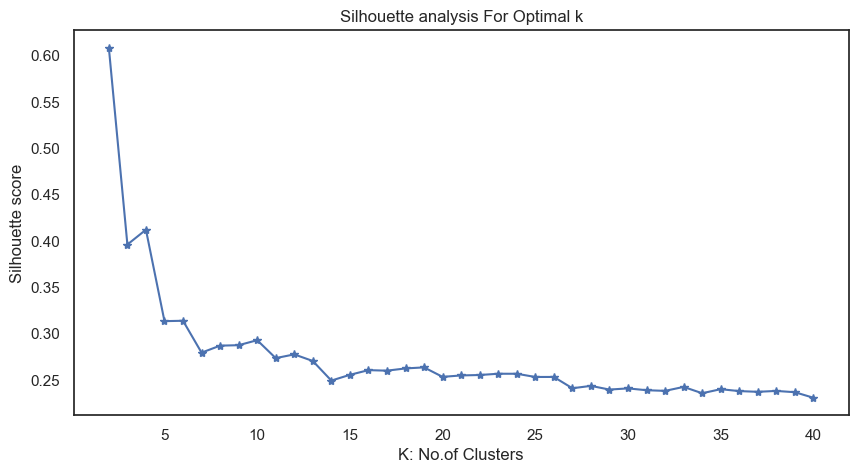

CPU times: total: 11min 59s
Wall time: 5min


In [64]:
%%time
# performing clustering using Kmeans 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # to evaluate clustering performance
silhouette_scr=[]
K=range(2,41)
for k in K:
    kmeans=KMeans(n_clusters=k,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
    kmeans=kmeans.fit(X_train)
    labels=kmeans.labels_
    
    # silhouette score
    silhouette_scr.append(silhouette_score(X_train,labels))

plt.plot(K,silhouette_scr,'b*-')
plt.xlabel('K: No.of Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [65]:
# will group data into 5 clusters
best_k=5
kmeans=KMeans(n_clusters=best_k,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
kmeans=kmeans.fit(X_train)

In [66]:
labels=kmeans.labels_ # labels for each product given by clustering model
len(labels)

21648

In [67]:
# getting centroids
cluster_centers=kmeans.cluster_centers_
cluster_centers

array([[ 0.10813467,  0.02739238,  0.70960221,  0.26300482,  0.8828916 ],
       [ 0.10651338,  0.08750694,  0.85082136,  0.06166144, -0.11017345],
       [ 0.53763415,  0.03489342,  0.64349216,  0.3216    ,  0.91124966],
       [ 0.10826748,  0.04945531,  0.77143948,  0.17910274,  0.4950651 ],
       [ 0.10504246,  0.03603091,  0.54762706,  0.41634501,  0.93902273]])

In [68]:
#saving cluster centers to pkl file
pickle.dump(cluster_centers,open('cluster_centers.pkl','wb'))

In [69]:
# inserting cluster_label as column 
data_train['cluster_label']=labels
data_train.head()

,product,category,sub_category,brand,type,description,sale_price,market_price,negative,neutral,positive,compound,sale_price_scaled,cluster_label
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.0,60.0,0.0,1.000,0.000,0.0000,0.027308,1
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.0,125.0,0.0,0.611,0.389,0.9484,0.061350,4
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.0,225.0,0.0,0.811,0.189,0.8126,0.098396,0
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.5,65.0,0.0,0.780,0.220,0.9723,0.028059,0
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.0,10.0,0.0,0.667,0.333,0.8402,0.003780,0


In [70]:
#saving preprocessed train data to csv
data_train.to_csv('train_preprocessed_with_clusterlabels.csv',index=False)

In [71]:
# saving raw test data to csv
data_test.to_csv('test_raw.csv',index=False)

In [73]:
# load preprocessed train data
df=pd.read_csv('train_preprocessed_with_clusterlabels.csv')
df.head()

,product,category,sub_category,brand,type,description,sale_price,market_price,negative,neutral,positive,compound,sale_price_scaled,cluster_label
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.0,60.0,0.0,1.000,0.000,0.0000,0.027308,1
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.0,125.0,0.0,0.611,0.389,0.9484,0.061350,4
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.0,225.0,0.0,0.811,0.189,0.8126,0.098396,0
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.5,65.0,0.0,0.780,0.220,0.9723,0.028059,0
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.0,10.0,0.0,0.667,0.333,0.8402,0.003780,0


In [74]:
df.columns
df.shape

(21648, 14)

In [75]:
import os

# Path to the GloVe text file
glove_file_path = r'C:\Users\harshita.chigati\Desktop\Python files\NLP\glove_data\glove.6B.50d.txt'

# Check if the file exists
if os.path.isfile(glove_file_path):
    # Read the GloVe file and process its contents
    glove_words = set()
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word_vector = line.split()
            word = word_vector[0]  # Extract the word
            glove_words.add(word)
else:
    print(f"The GloVe file '{glove_file_path}' does not exist.")

# Now glove_words contains the set of words in the GloVe file


In [76]:
# Check if the file exists
if os.path.isfile(glove_file_path):
    # Create a dictionary to store word vectors
    glove_vectors = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = list(map(float, values[1:]))
            glove_vectors[word] = vector
else:
    print(f"The GloVe file '{glove_file_path}' does not exist.")

# Now glove_vectors is a dictionary where keys are words and values are their corresponding vectors


### NER

In [77]:
import pandas as pd
import spacy

# Load SpaCy English language model (large)
nlp = spacy.load("en_core_web_lg")

In [78]:
# Function to perform NER on description
def perform_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER to description column
df['ner_entities'] = df['description'].apply(perform_ner)

# Display the DataFrame with NER entities
print(df[['description', 'ner_entities']])

print(df)

                                             description  \
0                                       per calories fat   
1      real good veg burger patty choice eating beefy...   
2      rice dosa easy make premium dosa mix used make...   
3      puramate skimmed milk powder makes wholesome m...   
4      ala fresh kiwi fruit drink refreshing fruit dr...   
...                                                  ...   
21643  biotique tea tree anti imperfection daily solu...   
21644  adore flawless skin wish perfect skin tone fee...   
21645  paw sitively smooth protects lovely pooch paws...   
21646  colorsilk ammonia permanent hair colour infuse...   
21647  refill pack adjustable major brands light weig...   

                                  ner_entities  
0                                           []  
1                             [(indian, NORP)]  
2      [(rice dosa, ORG), (idlis kanjis, ORG)]  
3                                           []  
4                [(ala, ORG), (tha

In [79]:
# Flatten the list of entities and get the second element of each tuple (which represents the entity group)
flat_entity_groups = [entity[1] for sublist in df['ner_entities'] for entity in sublist]

# Get unique entity groups
unique_entity_groups = set(flat_entity_groups)

# Display the unique entity groups
print("Unique entity groups:", unique_entity_groups)

Unique entity groups: {'QUANTITY', 'PRODUCT', 'ORG', 'PERSON', 'NORP', 'GPE', 'LOC', 'TIME', 'WORK_OF_ART', 'ORDINAL', 'FAC', 'EVENT', 'MONEY', 'LANGUAGE', 'DATE', 'CARDINAL', 'PERCENT', 'LAW'}


In [80]:
# Create separate columns for each entity group
for entity_group in unique_entity_groups:
    column_name = f"{entity_group.lower()}_entities"  # New column name based on entity group
    df[column_name] = df['ner_entities'].apply(lambda x: [entity[0] for entity in x if entity[1] == entity_group])

# Display the DataFrame with separate columns for each entity group
print(df[['product', 'category', 'sub_category', 'brand', 'sale_price', 'market_price', 'type', 'description', 'ner_entities'] + [f"{entity_group.lower()}_entities" for entity_group in unique_entity_groups]])


                                         product               category  \
0                                   Flour - Corn  foodgrains_oil_masala   
1                              Veg. Burger Patty    snacks_brandedfoods   
2                                 Dosa Rice/Akki  foodgrains_oil_masala   
3                            Skimmed Milk Powder      gourmet_worldfood   
4                                     Kiwi Drink      gourmet_worldfood   
...                                          ...                    ...   
21643  Tea Tree Anti Imperfection Daily Solution         beauty_hygiene   
21644                  Intimate Lightening Serum         beauty_hygiene   
21645    Paw'sitively Smooth Paw Butter For Dogs    kitchen_garden_pets   
21646         Colorsilk Hair Colour With Keratin         beauty_hygiene   
21647  Wet Mop - Micro Fiber Floor Square Refill     cleaning_household   

               sub_category          brand  sale_price  market_price  \
0            organicstaples

In [81]:
from spacy.lang.en.stop_words import STOP_WORDS

# Function to process text
def process_entities(entities):
    processed_entities = []
    for entity in entities:
        # Tokenization and lemmatization
        doc = nlp(entity)
        tokens = [token.lemma_ for token in doc]
        # Stopword removal
        tokens = [token for token in tokens if token.lower() not in STOP_WORDS]
        processed_entities.extend(tokens)
    return processed_entities

# Process entities columns
for entity_group in unique_entity_groups:
    column_name = f"{entity_group.lower()}_entities"
    df[column_name] = df[column_name].apply(lambda x: process_entities(x) if isinstance(x, list) else [])

# Display the DataFrame with processed entities columns
print(df[['product', 'category', 'sub_category', 'brand', 'sale_price', 'market_price', 'type', 'description', 'ner_entities'] + [f"{entity_group.lower()}_entities" for entity_group in unique_entity_groups]])


                                         product               category  \
0                                   Flour - Corn  foodgrains_oil_masala   
1                              Veg. Burger Patty    snacks_brandedfoods   
2                                 Dosa Rice/Akki  foodgrains_oil_masala   
3                            Skimmed Milk Powder      gourmet_worldfood   
4                                     Kiwi Drink      gourmet_worldfood   
...                                          ...                    ...   
21643  Tea Tree Anti Imperfection Daily Solution         beauty_hygiene   
21644                  Intimate Lightening Serum         beauty_hygiene   
21645    Paw'sitively Smooth Paw Butter For Dogs    kitchen_garden_pets   
21646         Colorsilk Hair Colour With Keratin         beauty_hygiene   
21647  Wet Mop - Micro Fiber Floor Square Refill     cleaning_household   

               sub_category          brand  sale_price  market_price  \
0            organicstaples

In [82]:
# Remove brackets and quotes from the values in entity columns
for entity_group in unique_entity_groups:
    column_name = f"{entity_group.lower()}_entities"
    df[column_name] = df[column_name].apply(lambda x: x[0] if len(x) > 0 else None)

# Display the DataFrame with separate columns for each entity group
print(df[['product', 'category', 'sub_category', 'brand', 'sale_price', 'market_price', 'type', 'description', 'ner_entities'] + [f"{entity_group.lower()}_entities" for entity_group in unique_entity_groups]])


                                         product               category  \
0                                   Flour - Corn  foodgrains_oil_masala   
1                              Veg. Burger Patty    snacks_brandedfoods   
2                                 Dosa Rice/Akki  foodgrains_oil_masala   
3                            Skimmed Milk Powder      gourmet_worldfood   
4                                     Kiwi Drink      gourmet_worldfood   
...                                          ...                    ...   
21643  Tea Tree Anti Imperfection Daily Solution         beauty_hygiene   
21644                  Intimate Lightening Serum         beauty_hygiene   
21645    Paw'sitively Smooth Paw Butter For Dogs    kitchen_garden_pets   
21646         Colorsilk Hair Colour With Keratin         beauty_hygiene   
21647  Wet Mop - Micro Fiber Floor Square Refill     cleaning_household   

               sub_category          brand  sale_price  market_price  \
0            organicstaples

In [83]:
# Remove the ner_entities column from df
df = df.drop(columns=['ner_entities'])

# Display the DataFrame with processed entities columns and without the ner_entities column
print(df)

df.dtypes

                                         product               category  \
0                                   Flour - Corn  foodgrains_oil_masala   
1                              Veg. Burger Patty    snacks_brandedfoods   
2                                 Dosa Rice/Akki  foodgrains_oil_masala   
3                            Skimmed Milk Powder      gourmet_worldfood   
4                                     Kiwi Drink      gourmet_worldfood   
...                                          ...                    ...   
21643  Tea Tree Anti Imperfection Daily Solution         beauty_hygiene   
21644                  Intimate Lightening Serum         beauty_hygiene   
21645    Paw'sitively Smooth Paw Butter For Dogs    kitchen_garden_pets   
21646         Colorsilk Hair Colour With Keratin         beauty_hygiene   
21647  Wet Mop - Micro Fiber Floor Square Refill     cleaning_household   

               sub_category          brand                    type  \
0            organicstaples  

product                  object
category                 object
sub_category             object
brand                    object
type                     object
description              object
sale_price              float64
market_price            float64
negative                float64
neutral                 float64
positive                float64
compound                float64
sale_price_scaled       float64
cluster_label             int64
quantity_entities        object
product_entities         object
org_entities             object
person_entities          object
norp_entities            object
gpe_entities             object
loc_entities             object
time_entities            object
work_of_art_entities     object
ordinal_entities         object
fac_entities             object
event_entities           object
money_entities           object
language_entities        object
date_entities            object
cardinal_entities        object
percent_entities         object
law_enti

In [84]:
# tfidf vectorizer
tfidf=TfidfVectorizer()
tfidf_description=tfidf.fit_transform(df['description'])

In [85]:
df.dtypes

product                  object
category                 object
sub_category             object
brand                    object
type                     object
description              object
sale_price              float64
market_price            float64
negative                float64
neutral                 float64
positive                float64
compound                float64
sale_price_scaled       float64
cluster_label             int64
quantity_entities        object
product_entities         object
org_entities             object
person_entities          object
norp_entities            object
gpe_entities             object
loc_entities             object
time_entities            object
work_of_art_entities     object
ordinal_entities         object
fac_entities             object
event_entities           object
money_entities           object
language_entities        object
date_entities            object
cardinal_entities        object
percent_entities         object
law_enti

In [86]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names_out())


In [87]:
df1 = df.copy()

In [88]:
df1.head()

,product,category,sub_category,brand,type,description,sale_price,market_price,negative,neutral,...,work_of_art_entities,ordinal_entities,fac_entities,event_entities,money_entities,language_entities,date_entities,cardinal_entities,percent_entities,law_entities
0,Flour - Corn,foodgrains_oil_masala,organicstaples,organictattva,organicflours,per calories fat,57.0,60.0,0.0,1.000,...,None,None,None,None,None,None,None,None,None,None
1,Veg. Burger Patty,snacks_brandedfoods,frozenveggies_snacks,yummiez,frozenvegsnacks,real good veg burger patty choice eating beefy...,125.0,125.0,0.0,0.611,...,None,None,None,None,None,None,None,None,None,None
2,Dosa Rice/Akki,foodgrains_oil_masala,rice_riceproducts,supersaver,rawrice,rice dosa easy make premium dosa mix used make...,199.0,225.0,0.0,0.811,...,None,None,None,None,None,None,None,None,None,None
3,Skimmed Milk Powder,gourmet_worldfood,cooking_bakingneeds,puramate,baking_cakedecorations,puramate skimmed milk powder makes wholesome m...,58.5,65.0,0.0,0.780,...,None,None,None,None,None,None,None,None,None,None
4,Kiwi Drink,gourmet_worldfood,drinks_beverages,alafresh,gourmetjuices_drinks,ala fresh kiwi fruit drink refreshing fruit dr...,10.0,10.0,0.0,0.667,...,None,None,None,None,None,None,None,None,None,None


### TF-IDF Vectorization

In [89]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

# Fill missing values with empty strings in entity group columns
entity_group_columns = ['org_entities', 'product_entities', 'loc_entities', 'ordinal_entities', 'date_entities', 'person_entities', 'norp_entities', 'cardinal_entities', 'gpe_entities', 'time_entities', 'fac_entities']
df1[entity_group_columns] = df1[entity_group_columns].fillna('')

# Concatenate product, category, and subcategory columns with the description column
df1['text'] = df1['description'] + " " + df1['org_entities'] + " " + df1['product_entities'] + " " + df1['loc_entities'] + " " + df1['ordinal_entities'] + " " + df1['date_entities'] + " " + df1['person_entities'] + " " + df1['norp_entities'] + " " + df1['cardinal_entities'] + " " + df1['gpe_entities'] + " " + df1['time_entities'] + " " + df1['fac_entities']+ " " + " " + df1['category'] + " " + df1['sub_category'] + df1['brand'] + df1['type']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to obtain TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df1['text'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

# Calculate TF-IDF weighted GloVe vectors for each description
description_tfidf_w2v_vectors = []
for description in tqdm(df['description']): # for each description
    vectors = [] # store GloVe vectors for words in the description
    tf_idf_weights = [] # store TF-IDF weights for words in the description
    for word in description.split(): # for each word in description
        if (word in glove_vectors) and (word in tfidf_vectorizer.vocabulary_):
            vec = np.array(glove_vectors[word]) # getting the vector for each word
            tf_idf_index = tfidf_vectorizer.vocabulary_[word] # get the index of the word in the TF-IDF matrix
            tf_idf = tfidf_matrix[0, tf_idf_index] # get the TF-IDF value for the word
            vectors.append(vec)
            tf_idf_weights.append(tf_idf)
    if vectors:
        vectors = np.array(vectors)
        tf_idf_weights = np.array(tf_idf_weights)
        weighted_vectors = vectors * tf_idf_weights[:, np.newaxis] # apply TF-IDF weights to GloVe vectors
        avg_vector = np.mean(weighted_vectors, axis=0) # compute the average weighted GloVe vector
        description_tfidf_w2v_vectors.append(avg_vector)
    else:
        description_tfidf_w2v_vectors.append(np.zeros(300)) # handle case when no valid GloVe vectors are found


# Step 6: Store TF-IDF weighted Word2Vec vectors
df1['description_tfidf_w2v'] = description_tfidf_w2v_vectors


Shape of TF-IDF matrix: (21648, 30220)


100%|███████████████████████████████████████████████████████████████████████████| 21648/21648 [00:32<00:00, 657.79it/s]


In [90]:
# stacking all encoded categorical features, vectorized description text and scaled sael price,discount% and sentiment scores
X_train=np.hstack((description_tfidf_w2v_vectors,df1['category'].values.reshape(-1,1),df1['sub_category'].values.reshape(-1,1),df1['brand'].values.reshape(-1,1), \
                  df1['type'].values.reshape(-1,1),df1['sale_price_scaled'].values.reshape(-1,1), \
                  df1['negative'].values.reshape(-1,1),df1['neutral'].values.reshape(-1,1),df1['positive'].values.reshape(-1,1), \
                  df1['compound'].values.reshape(-1,1),df1['cluster_label'].values.reshape(-1,1)))

In [91]:
X_train.shape

(21648, 60)

In [99]:
# function to get sentiment scores 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def get_scores(data):
    """returns sentiment analysis scores for description feature"""
    sia=SentimentIntensityAnalyzer()
    
    negative=[]
    neu=[]
    pos=[]
    compound=[]
    if 'description' in data.columns:
        for value in (data['description']):
            i=sia.polarity_scores(value)['neg']
            j=sia.polarity_scores(value)['neu']
            k=sia.polarity_scores(value)['pos']
            l=sia.polarity_scores(value)['compound']
            
            negative.append(i)
            neu.append(j)
            pos.append(k)
            compound.append(l)
            
    data['negative']=negative
    data['neutral']=neu
    data['positive']=pos
    data['compound']=compound
    
    return data       

In [94]:
import numpy as np
import sys

def get_clusterlabel(X, means=cluster_centers):
    """Compute cluster label based on the nearest mean."""
    minimum = sys.maxsize
    index = -1
    
    for i in range(len(means)):
        if isinstance(X, list):
            X_array = np.array(X)
        else:
            X_array = X.values.reshape(1, -1)
        
        sum_squared_diff = 0
        for j in range(len(X_array)):
            diff = X_array[j] - means[i][j]
            sum_squared_diff += diff * diff
        
        euclidean_dist = np.sqrt(sum_squared_diff)
        
        if euclidean_dist < minimum:
            minimum = euclidean_dist
            index = i
            
    return index


### Recommending products

In [92]:
from sklearn.metrics.pairwise import linear_kernel

def get_similar_products(df1, user_input, X_train=X_train, num_results=5):
    # Convert user_input to string if it's not already
    user_input = str(user_input)

    # Filter DataFrame based on user input (category, subcategory, type, or brand)
    filtered_df = df1[(df1['category'].str.contains(user_input)) |
                      (df1['sub_category'].str.contains(user_input)) |
                      (df1['brand'] == user_input) |
                      (df1['type'] == user_input)]

    if filtered_df.empty:
        return "No products found for the specified input."

    # Compute cosine similarities using linear kernel
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Step 2: Compute average similarity scores for filtered products
    avg_similarity_scores = cosine_sim[filtered_df.index].mean(axis=0)

    # Step 3: Get indices of top 5 products with highest average similarity scores
    top_5_indices = avg_similarity_scores.argsort()[::-1][:5]

    # Step 4: Get product titles of top 5 recommended products within the filtered category, subcategory, or brand
    top_5_products = df1.iloc[top_5_indices]['product'].tolist()

    return top_5_products


In [93]:
# Prompt the user to enter their input
user_input = input("Enter category, subcategory, brand, or type: ")

# Call the function with the user input
similar_products = get_similar_products(df1, user_input, X_train, num_results=5)

# Print the results
print("Top 5 similar products:")
for i, product in enumerate(similar_products, start=1):
    print(f"{i}. {product}")


Enter category, subcategory, brand, or type:  nivea


Top 5 similar products:
1. Crème Care Women Body Wash - Shower Gel For Soft Skin
2. Creme Care Soap - For Hands & Body
3. Soap - Creme Care
4. Women Deodorant, Protect & Care, Non-Irritating & 48h Protection With Creme Fragrance
5. Women Deodorant, Protect & Care, Non-Irritating & 48h Protection With Creme Fragrance


In [96]:
from sklearn.preprocessing import MinMaxScaler
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

def get_similar_products_1(df1, user_input, X_train=X_train, num_results=5):
    # Convert user_input to string if it's not already
    user_input = str(user_input)

    # Filter DataFrame based on user input (category, subcategory, type, or brand)
    filtered_df = df1[(df1['category'].str.contains(user_input)) |
                      (df1['sub_category'].str.contains(user_input)) |
                      (df1['brand'] == user_input) |
                      (df1['type'] == user_input)]

    if filtered_df.empty:
        return "No products found for the specified input."

    # Compute cosine similarities using linear kernel
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Step 2: Compute average similarity scores for filtered products
    avg_similarity_scores = cosine_sim[filtered_df.index].mean(axis=0)

    # Step 3: Get indices of top 10 products with highest average similarity scores
    top_10_indices = avg_similarity_scores.argsort()[::-1][:10]

    # Step 4: Get product titles of top 10 recommended products within the filtered category, subcategory, or brand
    top_10_products = df1.iloc[top_10_indices]['product'].tolist()

    return top_10_products


In [101]:
# Prompt the user to enter their input
user_input = input("Enter category, subcategory, brand, or type: ")

# Get the top 10 products based on user input
top_10_products = get_similar_products_1(df1, user_input, X_train, num_results=10)

# Remove duplicates from the top 10 products list
unique_top_10_products = list(set(top_10_products))

# Print the top 10 products
print("Top 10 products based on user input:")
for i, product in enumerate(unique_top_10_products, start=1):
    print(f"{i}. {product}")

# Apply sentiment score analysis to get the top 5 unique products
top_10_df = df1[df1['product'].isin(unique_top_10_products)]  # Subset DataFrame to include only unique top 10 products
top_10_df_with_scores = get_scores(top_10_df)  # Apply sentiment score analysis to top 10 products

# Sort top 10 products by compound sentiment score
top_10_df_sorted = top_10_df_with_scores.sort_values(by='compound', ascending=False)

# Get the final top 5 unique products after sorting by sentiment score
top_5_products = top_10_df_sorted['product'].unique()[:5]

# Print the top 5 unique products after sentiment score analysis
print("\nTop 5 unique products after sentiment score analysis:")
for i, product in enumerate(top_5_products, start=1):
    print(f"{i}. {product}")

Enter category, subcategory, brand, or type:  nivea


Top 10 products based on user input:
1. Soap - Creme Care
2. Creme Care Soap - For Hands & Body
3. Soft Light Moisturiser For Face, Hand & Body - Non-Sticky Cream With Vitamin E & Jojoba Oil
4. Soft - Light Moisturiser With Vitamin E
5. Crème Care Women Body Wash - Shower Gel For Soft Skin
6. Aloe Protection Body Lotion - SPF 15, For Men & Women
7. Women Deodorant, Protect & Care, Non-Irritating & 48h Protection With Creme Fragrance
8. Soft Light Moisturising Cream - Chilled Mint

Top 5 unique products after sentiment score analysis:
1. Creme Care Soap - For Hands & Body
2. Soap - Creme Care
3. Soft Light Moisturising Cream - Chilled Mint
4. Soft Light Moisturiser For Face, Hand & Body - Non-Sticky Cream With Vitamin E & Jojoba Oil
5. Crème Care Women Body Wash - Shower Gel For Soft Skin
